## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

> The total number of rows in dataset are **294478**

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.groupby('converted')['user_id'].nunique()[1]/df.groupby('converted')['user_id'].nunique().sum()

0.12068362109192721

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('(group=="treatment" and landing_page!="new_page") or (group!="treatment" and landing_page=="new_page")').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

> No rows missing values. i.e. There is no NaN in the dataset.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset.  Store your new dataframe in **df2**.

In [8]:
index_of_wrong_mapped_cols = df.query('(group=="treatment" and landing_page!="new_page") or (group=="control" and landing_page!="old_page")').index

In [9]:
df2 = df.drop(index_of_wrong_mapped_cols, axis=0)

In [10]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

> User id of user having duplicated entry is  **773192**

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates(subset='user_id', inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

> Total proportion of converted: **0.1196**

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2[df2['group'] == 'control'].converted.mean()

0.1203863045004612

> Proportion of converted for **control** group : **0.12**

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2[df2['group'] == 'treatment'].converted.mean()

0.11880806551510564

> Proportion of converted for **treatment** group : **0.1188**

d. What is the probability that an individual received the new page?

In [18]:
df2[df2.landing_page == 'new_page'].shape[0]/df2.shape[0]

0.5000619442226688

In [19]:
df2[df2.landing_page == 'old_page'].shape[0]/df2.shape[0]

0.4999380557773312

> Probability of individual receiving either page is **0.5**

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

> The probability of individual receiving either page is equal. The proportion of receiving a **new page** and getting converted is **0.1188** and proportion of receiving an **old page** and getting converted is **0.12**. So, from the given data, **old page led to more conversions**.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null hypothesis**        : The new page is either worst or same as that of the old page. i.e. The difference between the converted rates of new page and old page is less than or equal to zero.

**Alternative Hypothesis** : The new page is actually batter than the old page. i.e. The difference between the converted rates of new page and old page is greater than zero.

**Mathematically**:
\begin{align}
\\
H_0 : p_{new} \le p_{old} \; or \; p_{new} - p_{old} \le 0 \\
H_a : p_{new} \gt p_{old} \; or \; p_{new} - p_{old} \gt 0 
\end{align}

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

> The value of convert rate for **$p_{new}$** under null is **0.1196** which is the convert rate of whole data.

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = p_new

> The convert rate of **$p_{old}$** under null will be equal to **$p_{new}$** i.e. **0.1196** as both are equal under null hypothesis.

c. What is $n_{new}$?

In [22]:
n_new = df2.query('group == "treatment"')['converted'].count()
n_new

145310

> The value of number of rows (**$n_{new}$**) with **new page** as landing page is **145310**.

d. What is $n_{old}$?

In [23]:
n_old = df2.query('group == "control"')['converted'].count()
n_old

145274

> The value of number of rows (**$n_{old}$**) with **old page** as landing page is **145274**.

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted.mean()-old_page_converted.mean()

-0.00014670566009628017

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [27]:
new_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_simulation - old_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

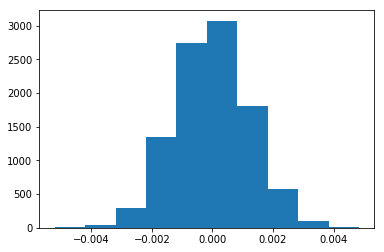

In [28]:
plt.hist(p_diffs);

> We have calculated the mean difference of the sampling dustribution (with bootstraping) of convert rate for new and old page. The data follows the **CLT (Central Limit Theorem)** and is in normal distribution shape.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
obs_diff = df2.query('group=="treatment"')['converted'].mean() - df2.query('group=="control"')['converted'].mean()
obs_diff

-0.0015782389853555567

> The **Observed Difference** is **-0.001578**

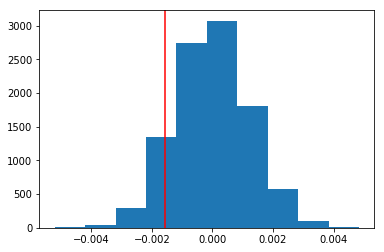

In [30]:
plt.hist(p_diffs)
plt.axvline(obs_diff, c='r');

> As we can see from the histogram above that a large portion of values are above the observed value. It means we **fail to reject the null hypothesis**.

In [31]:
(p_diffs > obs_diff).mean()

0.90169999999999995

> The **p-value** for distribution under null hypothesis is **0.902** which is way larger than **$\alpha$** of 0.05.

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> In **j** part, we computed the observed difference between the **$p_{new}$** and **$p_{old}$**. This value is used to calculate the **p-value** of our statistic by simulating the distribution under the **null hypothesis** and finding the probability that statistic came from that distribution.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2.query('group=="control" and converted == 1')['converted'].count()
convert_new = df2.query('group=="treatment" and converted == 1')['converted'].count()
n_old = df2.query('group=="control"')['group'].count()
n_new = df2.query('group=="treatment"')['group'].count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> The **z score** tell us about how many standard deviations below or above from the population mean, our observed value is. Since we got a z-score of **-1.31**, our value is 1.31 standard deviations below the population mean.

> The **p-value** is **0.905**, which is more than the **Type I** threshold value of **0.05**. It is similar to the value we calculated by simulating sample distribution from the null. So, on the basis of this, we **fail to reject null hypothesis**.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> Since, each row is either conversion or no conversion. We have only two discrete values of **0** or **1**. Therefore, we will use Logistic Regression a.k.a. Categorical Regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2['intercept'] = 1

In [35]:
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])

In [36]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [37]:
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 13 May 2018   Pseudo R-squ.:               8.077e-06
Time:                        14:42:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br> 

> The  **p-value** associated with the **ab_page** is **0.190** but the **p-value** calculated in the **Part II** was around **0.9**. This is happening because in case of simulating a sampling distribution and z-test, we tested the hypothesis for **one-sided *t-test***. But regression model tested the hypothesis for a **two-sided *t-test***.<br/><br/>
Since the **p-value** from Regression **(0.19)** is greater than the alpha threshold value of 0.05, **We fail to reject the Null Hypothesis**. It means that the new page is not performing better than the old page.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<ul>
    <li>It is a good idea to consider other factors to add to regression model because there are chances that other factors contribute to check whether an individual converts or not. </li>
    <li>There are some disadvantages though. Like, Two or more features can be interdependent on each other i.e **multicollinearity**. Thus, can make the estimate inaccurate.</li>
</ul>

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns. Provide the statistical output as well as a written response to answer this question.

In [39]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [40]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [41]:
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [42]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

In [43]:
model = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']]).fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [44]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 13 May 2018   Pseudo R-squ.:               2.323e-05
Time:                        14:42:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [45]:
print('UK is having {:0.4f} times more converted users than US, all other features held constant.'.format(np.exp(0.0099)))

UK is having 1.0099 times more converted users than US, all other features held constant.


In [46]:
print('US is having {:0.4f} times more converted users than UK, all other features held constant.'.format(1/np.exp(-0.0408)))

US is having 1.0416 times more converted users than UK, all other features held constant.


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
df_new['interaction_ab_CA'] = df_new['ab_page']*df_new['CA']
df_new['interaction_ab_UK'] = df_new['ab_page']*df_new['UK']

In [48]:
model = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'interaction_ab_CA', 'interaction_ab_UK']]).fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [49]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 13 May 2018   Pseudo R-squ.:               3.482e-05
Time:                        14:42:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page              -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA                   -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK                   -0.0057      0.019     -0.306      0.760      -0.043       0.031
interaction_ab_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
interaction_ab_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
=====================================================================================
"""

> The **p_value** of all the estimators is greater than the **$\alpha$** threshold value of **0.05**, which provides same result as before despite the fact that we have added more features. The conclusion based on the given data: we **fail to reject the Null Hypothesis**.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [50]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0